In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    evaluate_loop, 
    read_and_window_nursing_session,
    read_nursing_session,
    train_loop,
    optimization_loop,
    predict_and_plot_pretty_session
)
from lib.utils import (
    plot_and_save_cm,
    summary
)
from lib.models import  MLP, MLP2hl
from tqdm import tqdm
import plotly.express as px
from tabulate import tabulate

In [4]:
raw_dir = Path("/home/musa/datasets/nursingv1")
label_dir = Path("/home/musa/datasets/eating_labels")
WINSIZE = 101
DEVICE = 'cuda:1'

In [6]:
train_sessions = [25, 67, 42, 50, 22, 61, 33, 21, 16, 18]
test_sessions = [58, 62]

Xs = []
ys = []

for session_idx in train_sessions:
    X,y = read_and_window_nursing_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xtr = torch.cat(Xs)
ytr = torch.cat(ys)

Xs = []
ys = []

for session_idx in test_sessions:
    X,y = read_and_window_nursing_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xte = torch.cat(Xs)
yte = torch.cat(ys)

In [7]:
model = MLP2hl([20,20], WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [8]:
trainloader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)

In [ ]:

optimization_loop(model, trainloader, testloader, criterion, optimizer, 50, DEVICE, Path('dev/mlp2hl_3'))

In [9]:
# model.load_state_dict(torch.load(Path('dev/mlp2hl/best_model.pt')))
model.load_state_dict(torch.load(Path('dev/mlp2hl/best_model.pt')))

<All keys matched successfully>

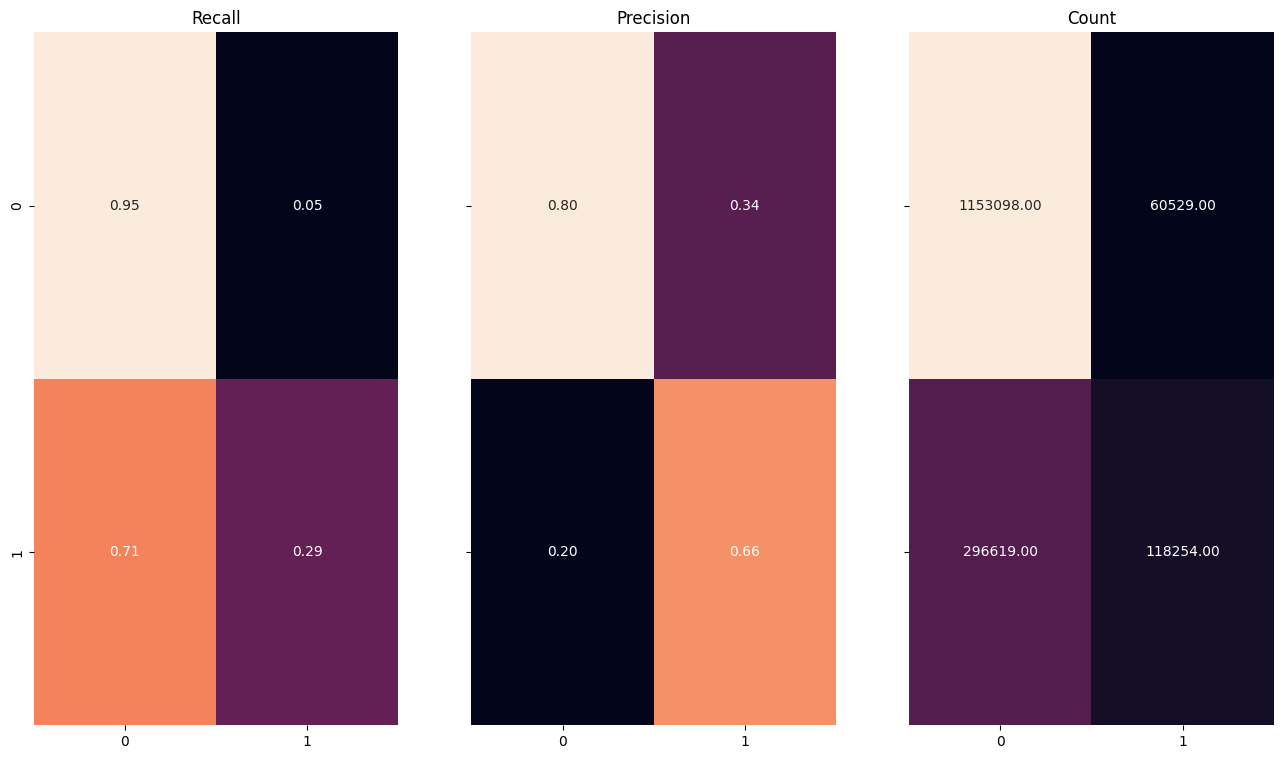

Metric        Value
---------  --------
loss       0.628964
precision  0.661439
recall     0.285037
f1         0.398392


In [10]:
ys,metrics = evaluate_loop(model, criterion, trainloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

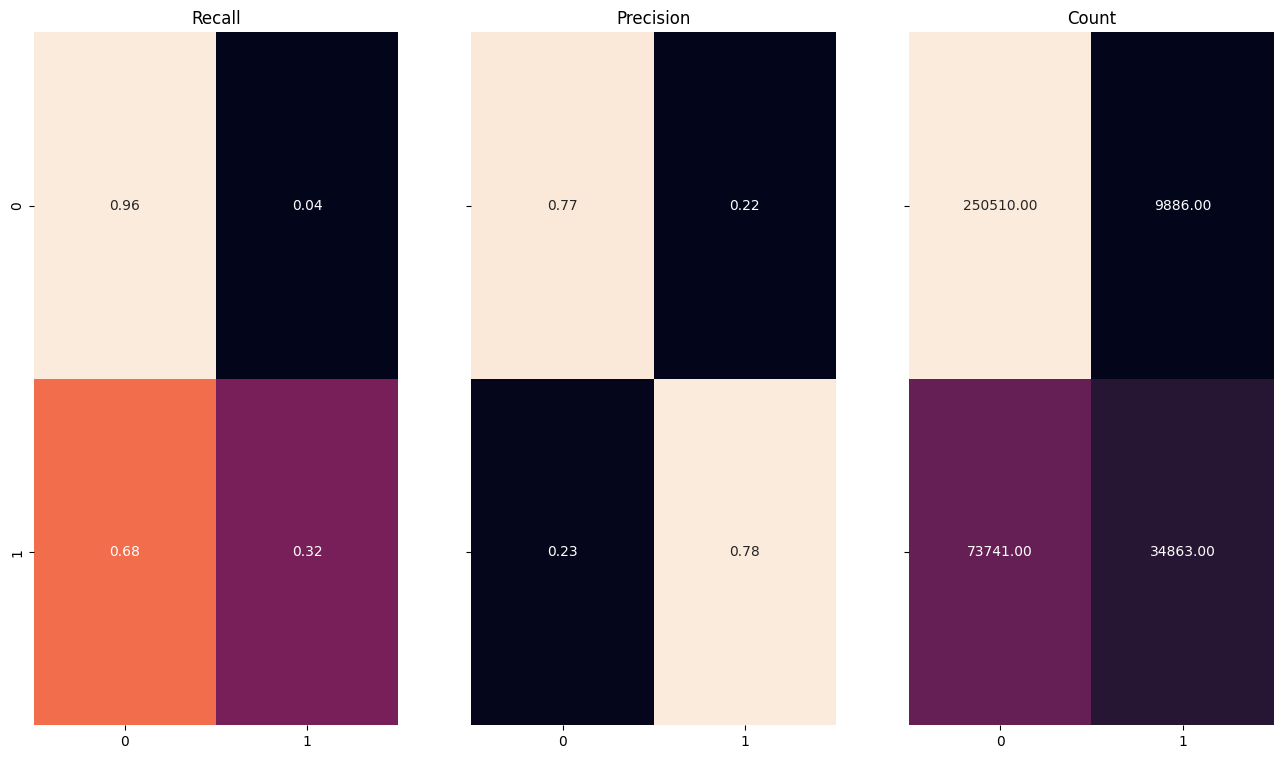

Metric        Value
---------  --------
loss       0.680095
precision  0.779079
recall     0.32101
f1         0.454676


In [11]:
ys,metrics = evaluate_loop(model, criterion, testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

In [13]:
test_session = test_sessions[0]

predict_and_plot_pretty_session(
    session_idx=test_session,
    dim_factor=5,
    datapath=raw_dir,
    labelpath=label_dir,
    winsize=WINSIZE,
    model=model,
    criterion=criterion,
    batch_size=64,
    device=DEVICE
)

Metric        Value
---------  --------
loss       0.473351
precision  0.608691
recall     0.140866
f1         0.228786
